In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    RobertaTokenizer, 
    RobertaForSequenceClassification, 
    RobertaConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import evaluate
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define constants
MAX_LEN = 512
TARGET_COLUMNS = ['humor', 'offensiveness', 'clarity', 'surprise_factor', 
                 'relatability', 'novelty', 'conciseness', 'sentiment']
NUM_TARGETS = len(TARGET_COLUMNS)
MODEL_CHECKPOINT = "FacebookAI/roberta-base" 

In [ ]:


class LossHistory(TrainerCallback):
    def __init__(self):
        self.train_losses = []  # to store (global_step, training loss)
        self.eval_losses = []   # to store (global_step, evaluation loss)
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Log training loss if available
        if logs is not None and "loss" in logs:
            self.train_losses.append((state.global_step, logs["loss"]))
    
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Log evaluation loss if available
        if metrics is not None and "eval_loss" in metrics:
            self.eval_losses.append((state.global_step, metrics["eval_loss"]))


def plot_predicted_vs_actual(predictions_unscaled, actual_values_unscaled, target_columns, save_path="predicted_vs_actual.png"):
    """
    Generates and saves a scatter plot of predicted vs. actual values for each target dimension.
    
    Each plot includes:
      - A scatter plot of actual vs. predicted values.
      - A diagonal line representing the ideal prediction (where predicted equals actual).
    
    Args:
        predictions_unscaled (np.ndarray): Array of unscaled predictions with shape (n_samples, num_targets).
        actual_values_unscaled (np.ndarray): Array of unscaled actual values with shape (n_samples, num_targets).
        target_columns (list of str): List of target column names.
        save_path (str): File path where the scatter plot image will be saved.
    
    Returns:
        None
    """
    num_targets = len(target_columns)
    
    if num_targets == 1:
        # Single target: create one plot
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(actual_values_unscaled[:, 0], predictions_unscaled[:, 0], alpha=0.6)
        # Determine the minimum and maximum values for the axis limits
        min_val = min(actual_values_unscaled[:, 0].min(), predictions_unscaled[:, 0].min())
        max_val = max(actual_values_unscaled[:, 0].max(), predictions_unscaled[:, 0].max())
        # Plot the ideal prediction line (diagonal)
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')
        ax.set_xlabel("Actual " + target_columns[0])
        ax.set_ylabel("Predicted " + target_columns[0])
        ax.set_title("Actual vs. Predicted for " + target_columns[0])
        ax.legend()
    else:
        # Multiple targets: create subplots for each target
        fig, axes = plt.subplots(1, num_targets, figsize=(5 * num_targets, 5))
        for i, ax in enumerate(axes):
            ax.scatter(actual_values_unscaled[:, i], predictions_unscaled[:, i], alpha=0.6)
            min_val = min(actual_values_unscaled[:, i].min(), predictions_unscaled[:, i].min())
            max_val = max(actual_values_unscaled[:, i].max(), predictions_unscaled[:, i].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')
            ax.set_xlabel("Actual " + target_columns[i])
            ax.set_ylabel("Predicted " + target_columns[i])
            ax.set_title("Actual vs. Predicted for " + target_columns[i])
            ax.legend()

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Predicted vs Actual scatter plot saved as '{save_path}'.")


def plot_loss_history(loss_history, save_path="loss_plot.png"):
    """
    Plots the training and evaluation loss curves stored in the loss_history callback.
    
    This function extracts the global steps and loss values from both training (on_log)
    and evaluation (on_evaluate) events, creates a plot showing both curves, draws legends
    and labels, then saves the plot to the given path.
    
    Args:
        loss_history: An instance of LossHistory that contains:
                      - train_losses: List of tuples (global_step, training loss)
                      - eval_losses:  List of tuples (global_step, evaluation loss)
        save_path (str): File path where the plot image will be saved.
    
    Returns:
        None
    """
    # Extract training losses
    if loss_history.train_losses:
        train_steps, train_loss_values = zip(*loss_history.train_losses)
    else:
        train_steps, train_loss_values = [], []
    
    # Extract evaluation losses
    if loss_history.eval_losses:
        eval_steps, eval_loss_values = zip(*loss_history.eval_losses)
    else:
        eval_steps, eval_loss_values = [], []
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_loss_values, label="Training Loss", marker='o')
    plt.plot(eval_steps, eval_loss_values, label="Evaluation Loss", marker='o')
    plt.xlabel("Global Step")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Over Time")
    plt.legend()
    plt.tight_layout()
    
    # Save and display the plot
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Loss plot saved as '{save_path}'.")


def load_data(file_path, nrows=None):
    # Load dataset from a Parquet file
    df = pd.read_parquet(file_path)
    if nrows:
        df = df.head(nrows)
    
    # Define the numerical columns:
    # Non-sentiment numerical columns
    non_sentiment_columns = [
        'humor', 'offensiveness', 'clarity', 
        'surprise_factor', 'relatability', 'novelty', 
        'conciseness'
    ]
    # Sentiment column as a separate list
    sentiment_column = ['sentiment']

    # First, apply the MinMaxScaler to the non-sentiment columns with a range of 0 to 100.
    minmax_scaler_non_sent = MinMaxScaler(feature_range=(0, 100))
    df[non_sentiment_columns] = minmax_scaler_non_sent.fit_transform(df[non_sentiment_columns])
    
    # Then, apply the MinMaxScaler to the sentiment column with a range of -100 to 100.
    minmax_scaler_sent = MinMaxScaler(feature_range=(-100, 100))
    df[sentiment_column] = minmax_scaler_sent.fit_transform(df[sentiment_column])
    
    # Combine all numerical columns for further scaling
    numerical_columns = non_sentiment_columns + sentiment_column
    
    # Now, apply StandardScaler to standardize (zero mean, unit variance) the already min-max scaled columns.
    standard_scaler = StandardScaler()
    df[numerical_columns] = standard_scaler.fit_transform(df[numerical_columns])
    
    return df, standard_scaler

# Custom dataset class
class JokeDataset(Dataset):
    def __init__(self, jokes, targets, tokenizer, max_len):
        self.jokes = jokes
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.jokes)
    
    def __getitem__(self, idx):
        joke = str(self.jokes[idx])
        targets = self.targets[idx].astype(np.float32)
        
        encoding = self.tokenizer.encode_plus(
            joke,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            # 'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(targets, dtype=torch.float32)
        }

# Define a custom model class for multiple regression
class RobertaForMultipleRegression(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None,
                output_attentions=None, output_hidden_states=None, return_dict=None):
        
        return super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            # token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )
    

# Define the compute_metrics function for Trainer
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Calculate MSE for each target dimension
    mse_per_target = []
    for i in range(NUM_TARGETS):
        mse = mean_squared_error(labels[:, i], predictions[:, i])
        mse_per_target.append(mse)
    
    # Calculate average MSE across all targets
    avg_mse = np.mean(mse_per_target)
    
    # Create result dictionary with individual and average MSE
    results = {"mse": avg_mse}
    for i, target in enumerate(TARGET_COLUMNS):
        results[f"mse_{target}"] = mse_per_target[i]
    
    return results

# Main function
def main(data_path, nrows):
    # Load data
    print(f"Loading data from {data_path}")
    df, scalar = load_data(data_path, nrows=nrows)

    # Split data into train, validation, and test sets (80%, 10%, 10%)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)
    
    print(f"Train set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
    
    # Create datasets
    train_dataset = JokeDataset(
        jokes=train_df['joke'].values,
        targets=train_df[TARGET_COLUMNS].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    val_dataset = JokeDataset(
        jokes=val_df['joke'].values,
        targets=val_df[TARGET_COLUMNS].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    test_dataset = JokeDataset(
        jokes=test_df['joke'].values,
        targets=test_df[TARGET_COLUMNS].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    
    # Configure the model for regression task
    config = AutoConfig.from_pretrained(MODEL_CHECKPOINT)
    config.num_labels = NUM_TARGETS
    config.problem_type = "regression"
    
    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CHECKPOINT,
        config=config
    )

    # Freeze all layers of the base model (RoBERTa)
    for param in model.base_model.parameters():
        param.requires_grad = False

    # Instantiate your loss history callback
    loss_history = LossHistory()
    
    # Set up training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=500,
        eval_steps=500,
        evaluation_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_mse",
        greater_is_better=False,
        save_total_limit=2,
        learning_rate=5.0e-5
        # fp16=True,  # Use mixed precision training if available
    )
    
    # Set up trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1), loss_history]
    )
    
    # Train the model
    print("Starting training...")
    trainer.train()

    plot_loss_history(loss_history, save_path="loss_plot.png")

    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_results = trainer.evaluate(test_dataset)
    print("Test results:", test_results)
    
    # Save model
    print("Saving model...")
    trainer.save_model("./joke_regression_model")

    # Save the scaler to the same directory as the model
    scaler_path = os.path.join("./joke_regression_model", "scaler.pkl")
    joblib.dump(scalar, scaler_path)
    print(f"Scaler saved to {scaler_path}")
    
    # Perform predictions on test set (for further analysis if needed)
    test_predictions = trainer.predict(test_dataset)
    predictions = test_predictions.predictions
    actual_values = test_predictions.label_ids

    predictions_unscaled = scalar.inverse_transform(predictions)
    actual_values_unscaled = scalar.inverse_transform(actual_values)

    plot_predicted_vs_actual(predictions_unscaled, actual_values_unscaled, TARGET_COLUMNS)
    
    # Return results
    return {
        "model": model,
        "test_results": test_results,
        "predictions": predictions_unscaled,
        "actual_values": actual_values_unscaled
    }

def predict_joke_ratings(joke_text, model_path="./joke_regression_model"):
    """
    Use the trained model to predict ratings for a new joke.
    
    Args:
        joke_text (str): The text of the joke to rate
        model_path (str): Path to the saved model
    
    Returns:
        dict: Predicted ratings for each dimension
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
    config = AutoConfig.from_pretrained(model_path)
    model = RobertaForMultipleRegression.from_pretrained(model_path, config=config)
    model.eval()
    
    # Tokenize the input joke text
    encoding = tokenizer.encode_plus(
        joke_text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Perform prediction
    with torch.no_grad():
        outputs = model(
            input_ids=encoding['input_ids'],
            attention_mask=encoding['attention_mask']
        )
        predictions = outputs.logits.cpu().numpy()[0]
    
    # Load the saved scaler for inverse transformation
    scaler_path = os.path.join(model_path, "scaler.pkl")
    scaler = joblib.load(scaler_path)
    
    # Reshape prediction to a 2D array (required by inverse_transform)
    predictions_reshaped = predictions.reshape(1, -1)
    predictions_unscaled = scaler.inverse_transform(predictions_reshaped)[0]
    
    # Format the output with proper target names
    result = {}
    for i, target in enumerate(TARGET_COLUMNS):
        result[target] = float(predictions_unscaled[i])
    
    return result


# Function to analyze model performance
def analyze_results(predictions, actual_values):
    """
    Analyze the model's performance on each target dimension.
    
    Args:
        predictions: Model predictions
        actual_values: Ground truth values
        
    Returns:
        dict: Performance metrics
    """
    results = {}
    
    # For each target dimension
    for i, target in enumerate(TARGET_COLUMNS):
        # Calculate MSE
        mse = mean_squared_error(actual_values[:, i], predictions[:, i])
        
        # Calculate correlation
        corr = np.corrcoef(predictions[:, i], actual_values[:, i])[0, 1]
        
        results[target] = {
            'mse': mse,
            'correlation': corr
        }
    
    # Calculate overall metrics
    results['overall'] = {
        'mse': mean_squared_error(actual_values.flatten(), predictions.flatten()),
        'correlation': np.corrcoef(predictions.flatten(), actual_values.flatten())[0, 1]
    }
    
    return results

Loading data from ../data/labeled_jokes.parquet
Train set: 800 samples
Validation set: 100 samples
Test set: 100 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss


Loss plot saved as 'loss_plot.png'.
Evaluating on test set...


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test results: {'eval_loss': 0.8845898509025574, 'eval_mse': 0.8845898285508156, 'eval_mse_humor': 0.8433429598808289, 'eval_mse_offensiveness': 0.836366593837738, 'eval_mse_clarity': 0.7643805742263794, 'eval_mse_surprise_factor': 0.9261776804924011, 'eval_mse_relatability': 0.8574045300483704, 'eval_mse_novelty': 0.9179797172546387, 'eval_mse_conciseness': 0.8448205590248108, 'eval_mse_sentiment': 1.0862460136413574, 'eval_runtime': 1.877, 'eval_samples_per_second': 53.276, 'eval_steps_per_second': 0.533, 'epoch': 10.0}
Saving model...
Scaler saved to ./joke_regression_model/scaler.pkl


/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Predicted vs Actual scatter plot saved as 'predicted_vs_actual.png'.

Analyzing model performance:
humor: MSE = 675.0753, Correlation = -0.0833
offensiveness: MSE = 455.0900, Correlation = 0.0172
clarity: MSE = 123.0716, Correlation = 0.1406
surprise_factor: MSE = 407.6650, Correlation = 0.1106
relatability: MSE = 174.7657, Correlation = 0.0835
novelty: MSE = 142.5194, Correlation = 0.0356
conciseness: MSE = 112.0176, Correlation = -0.0210
sentiment: MSE = 2231.1042, Correlation = -0.0263
Overall: MSE = 540.1636, Correlation = 0.7838

Example prediction:
humor: 86.86
offensiveness: 13.43
clarity: 84.91
surprise_factor: 62.83
relatability: 32.47
novelty: 25.24
conciseness: 89.40
sentiment: 32.80


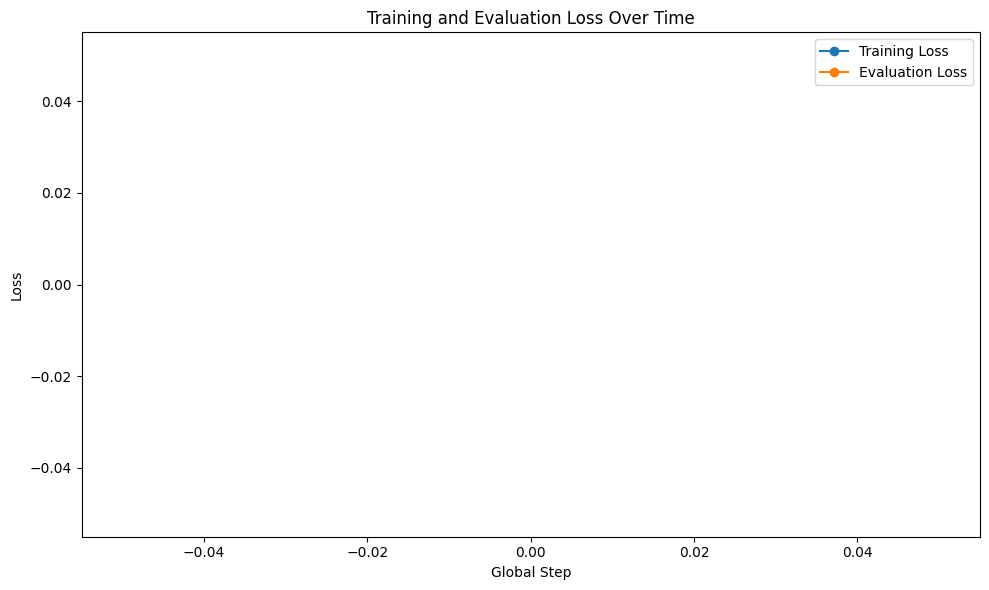

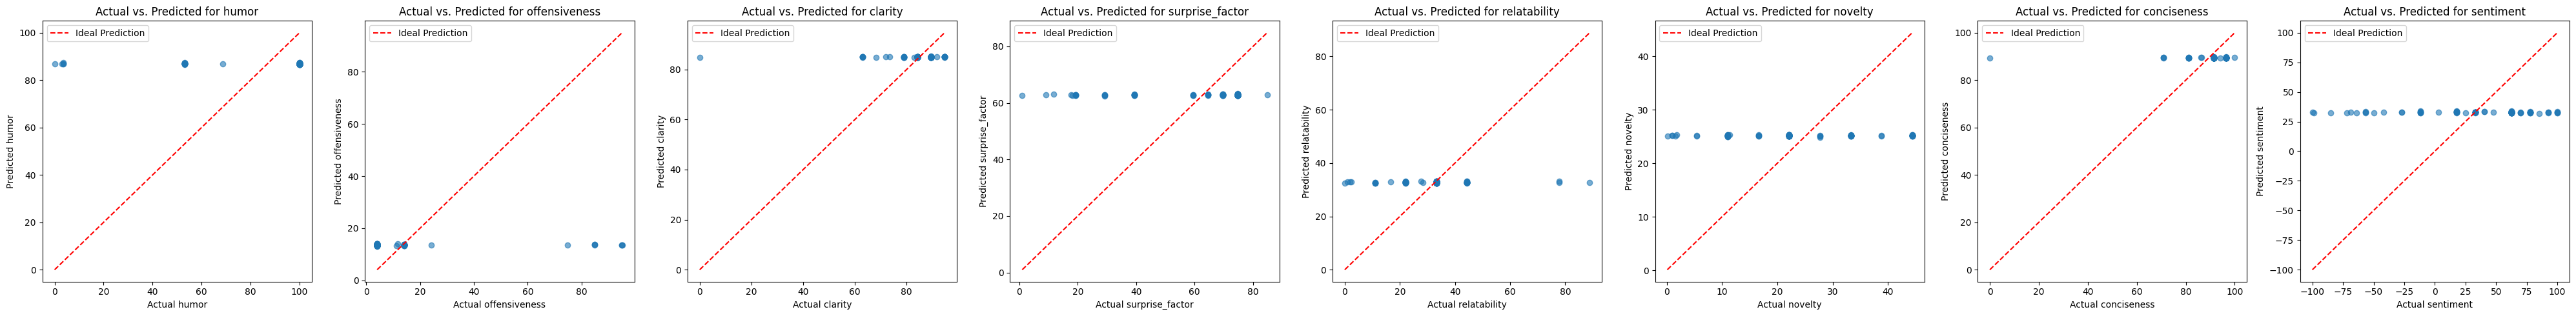

In [ ]:
# Replace with your actual file path
data_path = "../data/labeled_jokes.parquet"
results = main(data_path, nrows=None)

# Analyze performance
print("\nAnalyzing model performance:")
performance = analyze_results(results["predictions"], results["actual_values"])
for dimension, metrics in performance.items():
    if dimension != 'overall':
        print(f"{dimension}: MSE = {metrics['mse']:.4f}, Correlation = {metrics['correlation']:.4f}")
print(f"Overall: MSE = {performance['overall']['mse']:.4f}, Correlation = {performance['overall']['correlation']:.4f}")

# Example of using the model with a new joke
print("\nExample prediction:")
sample_joke = "Why don't scientists trust atoms? Because they make up everything!"
predictions = predict_joke_ratings(sample_joke)
for dimension, score in predictions.items():
    print(f"{dimension}: {score:.2f}")

In [6]:
# Example of using the model with a new joke
print("\nExample prediction:")
sample_joke = "My boss told me to have a good day, so I went home."
predictions = predict_joke_ratings(sample_joke)
for dimension, score in predictions.items():
    print(f"{dimension}: {score:.2f}")


Example prediction:
humor: 87.16
offensiveness: 13.78
clarity: 85.01
surprise_factor: 62.85
relatability: 33.14
novelty: 25.19
conciseness: 89.62
sentiment: 33.34
